# Predicting LendingClub Loan Charge-offs from Loan Origination Data

***By Joe Corliss***

**June 14, 2018**

## Contents

* [1. Introduction](#1)
 * [1.1 References](#1.1)
* [2. Import the Data](#2)
* [3. Response Variable](#3)
* [4. Limit the Feature Space](#4)
 * [4.1 Drop features missing more than 30% data](#4.1)
 * [4.2 Only keep loan features known to potential investors](#4.2)
* [5. Pre-processing and Exploratory Analysis](#5)
* [6. More Pre-processing](#6)
 * [6.1 Convert loan status to 0/1 charge-off indicator](#6.1)
 * [6.2 Create dummy variables](#6.2)
 * [6.3 Train/test split](#6.3)
* [7. Linear Dependence of Charge-off on the Predictors](#7)
* [8. Model Training and Testing](#8)
 * [8.1 Logistic regression with SGD training](#8.1)
 * [8.2 Random forest classifier](#8.2)
 * [8.3 k-nearest neighbors](#8.3)
 * [8.4 Tune hyperparameters on the chosen model more finely](#8.4)
 * [8.5 Test set evaluation](#8.5)
* [9. Conclusion](#9)

# 1. Introduction
<a id="1"></a>

[LendingClub](https://www.lendingclub.com/) is a US peer-to-peer lending company and the world's largest peer-to-peer lending platform. As explained by [Wikipedia](https://en.wikipedia.org/wiki/Lending_Club),

> Lending Club enables borrowers to create unsecured personal loans between \$1,000 and \$40,000. The standard loan period is three years. Investors can search and browse the loan listings on Lending Club website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. Lending Club makes money by charging borrowers an origination fee and investors a service fee.

The goal of this project is to build a machine learning model to predict the probability that a loan will charge off. We will attempt to only use data available to investors via the LendingClub loan listing, including information about the borrower (income, employment length, FICO score, debt-to-income ratio, etc.) and the loan listing (the loan amount, loan purpose, loan grade, interest rate, installment, etc.). Such a predictive model could help LendingClub investors make better-informed investment decisions. We will only consider loans that LendingClub accepted under its credit underwriting policy.

## 1.1 References
<a id="1.1"></a>

* LendingClub information
 * [LendingClub website](https://www.lendingclub.com/)
 * [LendingClub Wikipedia page](https://en.wikipedia.org/wiki/Lending_Club)
* Datasets
 * [LendingClub statistics](https://www.lendingclub.com/info/download-data.action) - Original data source, aggregated on Kaggle
 * [All Lending Club loan data](https://www.kaggle.com/wordsforthewise/lending-club) - The dataset used in this project, hosted on Kaggle
 * [Lending Club Loan Data](https://www.kaggle.com/wendykan/lending-club-loan-data) - Another LendingClub dataset on Kaggle, not used in this project
* This project
 * [Kaggle notebook](https://www.kaggle.com/pileatedperch/predicting-charge-off-from-initial-listing-data)
 * [GitHub repo](https://github.com/jgcorliss/lending-club)

# 2. Import the Data
<a id="2"></a>

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

Read the data into a pandas dataframe:

In [2]:
loans = pd.read_csv('accepted_2007_to_2017Q3.csv.gz', compression='gzip', low_memory=True)

C:\Users\Joe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,18,48,58,117,128,129,130,133,134,135,138,144,145,146) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Check basic dataframe info:

In [3]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646801 entries, 0 to 1646800
Columns: 150 entries, id to settlement_term
dtypes: float64(113), object(37)
memory usage: 1.8+ GB


There are 1.6 million rows and 150 variables. The size of the dataset is 1.8 GB.

Let's peek at 5 randomly selected rows. Each row corresponds to a single loan.

In [4]:
loans.sample(5)

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
1605390  70891233        NaN    18000.0      18000.0          18000.0   
237470    1044661        NaN    19400.0      19400.0          19400.0   
133849   12455743        NaN     9950.0       9950.0           9950.0   
381992   61473495        NaN    15000.0      15000.0          15000.0   
327913   65403207        NaN    18025.0      18025.0          18025.0   

               term  int_rate  installment grade sub_grade  \
1605390   36 months     10.75       587.17     B        B4   
237470    60 months     20.30       517.23     E        E5   
133849    36 months     10.99       325.71     B        B3   
381992    36 months     12.29       500.30     C        C1   
327913    36 months     14.33       618.95     C        C5   

                    emp_title emp_length home_ownership  annual_inc  \
1605390                 Owner    5 years           RENT    120000.0   
237470     Louis A. Roser Co.  10+ years           RENT     65000.0   
133849             Operations    5 years           RENT     25000.0   
381992       Customer Service    9 years           RENT     45000.0   
327913   Student coordinator     8 years           RENT     41000.0   

        verification_status   issue_d  loan_status pymnt_plan  \
1605390        Not Verified  Feb-2016      Current          n   
237470      Source Verified  Dec-2011  Charged Off          n   
133849      Source Verified  Jun-2014  Charged Off          n   
381992      Source Verified  Oct-2015   Fully Paid          n   
327913      Source Verified  Nov-2015      Current          n   

                                                                                   desc  \
1605390                                                                             NaN   
237470     Borrower added on 11/28/11 > Importing toys and electronics for re-sale.<br>   
133849                                                                              NaN   
381992                                                                              NaN   
327913                                                                              NaN   

                    purpose                title zip_code addr_state    dti  \
1605390  debt_consolidation   Debt consolidation    923xx         CA  13.20   
237470       small_business  Small Business Loan    840xx         UT   4.69   
133849   debt_consolidation   Debt consolidation    997xx         AK  13.27   
381992   debt_consolidation   Debt consolidation    920xx         CA  16.56   
327913   debt_consolidation   Debt consolidation    958xx         CA  25.53   

         delinq_2yrs earliest_cr_line  fico_range_low  fico_range_high  \
1605390          1.0         Apr-2002           715.0            719.0   
237470           0.0         Jul-1991           715.0            719.0   
133849           0.0         Jun-1990           670.0            674.0   
381992           0.0         Oct-2010           665.0            669.0   
327913           0.0         Dec-2000           695.0            699.0   

         inq_last_6mths  mths_since_last_delinq  mths_since_last_record  \
1605390             1.0                     6.0                     NaN   
237470              0.0                     NaN                     NaN   
133849              3.0                    68.0                     NaN   
381992              0.0                     NaN                     NaN   
327913              0.0                    59.0                     NaN   

         open_acc  pub_rec  revol_bal  revol_util  total_acc  \
1605390      22.0      0.0    15986.0        19.4       32.0   
237470        3.0      0.0    10457.0        73.5        4.0   
133849       12.0      0.0    12480.0        43.0       28.0   
381992        9.0      0.0    11536.0        67.1       10.0   
327913        6.0      0.0     5668.0        83.4        7.0   

        initial_list_status  out_prncp  out_prncp_inv   total_pymnt  \
1605390    

# 3. Response Variable
<a id="3"></a>

We're going to try to predict the `loan_status` variable. What are the value counts for this variable?

In [5]:
loans['loan_status'].value_counts(dropna=False)

Current                                                788950
Fully Paid                                             646902
Charged Off                                            168084
Late (31-120 days)                                      23763
In Grace Period                                         10474
Late (16-30 days)                                        5786
Does not meet the credit policy. Status:Fully Paid       1988
Does not meet the credit policy. Status:Charged Off       761
Default                                                    70
NaN                                                        23
Name: loan_status, dtype: int64

We're going to try to learn differences in the features between completed loans that have been fully paid or charged off. We won't consider loans that are current, don't meet the credit policy, defaulted, or have a missing status. So we only keep the loans with status "Fully Paid" or "Charged Off."

In [6]:
loans = loans.loc[loans['loan_status'].isin(['Fully Paid', 'Charged Off'])]

How many loans remain in the dataset?

In [7]:
loans.shape

(814986, 150)

There are 814,986 loans remaining. Check that the statuses are as expected:

In [8]:
loans['loan_status'].value_counts(dropna=False)

Fully Paid     646902
Charged Off    168084
Name: loan_status, dtype: int64

Status counts as percentages:

In [9]:
loans['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.793758
Charged Off    0.206242
Name: loan_status, dtype: float64

About 79% of the remaining loans have been fully paid and 21% have charged off, so we have a somewhat unbalanced classification problem.

# 4. Limit the Feature Space
<a id="4"></a>

The full dataset has 150 features for each loan. We'll select features in two steps:

1. Drop features with more than 30% of their data missing.
2. Of the remaining features, choose only those that would be available to an investor before deciding to fund the loan.

Definitions of the features are given in the LendingClub Data Dictionary [available here](https://www.lendingclub.com/info/download-data.action).

## 4.1 Drop features missing more than 30% data
<a id="4.1"></a>

First calculate the percentage of missing data for each feature:

In [10]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False)

Top 10 features missing the most data:

In [11]:
missing_fractions.head(10)

member_id                                     1.000000
next_pymnt_d                                  1.000000
orig_projected_additional_accrued_interest    0.999876
sec_app_mths_since_last_major_derog           0.999628
hardship_length                               0.999275
hardship_type                                 0.999275
hardship_reason                               0.999275
hardship_status                               0.999275
deferral_term                                 0.999275
hardship_amount                               0.999275
dtype: float64

Let's visualize the distribution of missing data percentages:

Text(0,0.5,'Feature count')

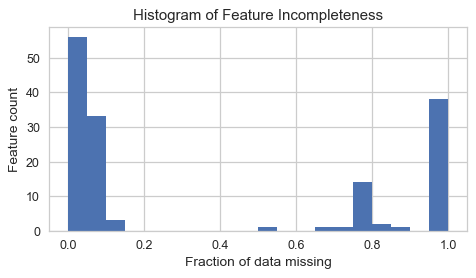

In [12]:
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

From the above histogram, we see there's a large gap between features missing "some" data (&lt;20%) and those missing "lots" of data (&gt;40%). Because it's generally very difficult to accurately impute data with more than 30% missing values, we drop such columns. First store all variables missing more than 30% data in an alphabetical list:

In [13]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

How many features will be dropped?

In [14]:
len(drop_list)

58

Drop these features:

In [15]:
loans.drop(labels=drop_list, axis=1, inplace=True)

In [16]:
loans.shape

(814986, 92)

## 4.2 Only keep loan features known to potential investors
<a id="4.2"></a>

We examine the LendingClub website and Data Dictionary to determine which features would have been available to potential investors. Here's the list of features we currently have, in alphabetical order:

In [17]:
print(sorted(loans.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sa

For each of these features, we check the description in the Data Dictionary and only keep the features that would have been available to investors considering an investment in the loan. These include features in the loan application, and any features added by LendingClub when the loan listing was accepted, such as the loan grade and interest rate.

I'm using my best available knowledge to determine which loan features are known to potential investors. I am not an investor on LendingClub, so my knowledge of the LendingClub investment process is not exact. When in doubt, I err on the side of dropping the feature.

In [18]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']

In [19]:
len(keep_list)

31

The list of features to drop is any feature not in `keep_list`:

In [20]:
drop_list = [col for col in loans.columns if col not in keep_list]
print(drop_list)

['funded_amnt', 'funded_amnt_inv', 'pymnt_plan', 'delinq_2yrs', 'inq_last_6mths', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75'

In [21]:
len(drop_list)

61

Drop these features:

In [22]:
loans.drop(labels=drop_list, axis=1, inplace=True)

In [23]:
loans.shape

(814986, 31)

# 5. Pre-processing and Exploratory Analysis
<a id="5"></a>

We'll inspect each feature individually, and do the following:

1. Drop the feature if it is not useful for predicting the loan status.
2. View summary statistics and visualize the data, plotting against the loan status.
3. Modify the feature to make it useful for modeling, if necessary.

We define a function for plotting a variable and comparing with the loan status:

In [24]:
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(loans[col_name], order=sorted(loans[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=loans, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = loans.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

Print the remaining features for future reference:

In [25]:
print(list(loans.columns))

['id', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies']


## 5.1 id

Data Dictionary: "A unique [LendingClub] assigned ID for the loan listing."

In [26]:
loans['id'].sample(5)

327317     65604280
1644795    68586579
227773     10636780
838555      7956003
46010      31547421
Name: id, dtype: object

Are all the IDs unique?

In [27]:
loans['id'].describe()

count       814986
unique      814986
top       14680062
freq             1
Name: id, dtype: int64

Yes, they are all unique. The ID is not useful for modeling, either as a categorical variable (there are too many distinct values) or as a numerical variable (the IDs vary wildly in magnitude, likely without any significance), so we drop this variable.

In [28]:
loans.drop('id', axis=1, inplace=True)

## 5.2 loan_amnt

Data Dictionary: "The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."

In [29]:
loans['loan_amnt'].describe()

count    814986.000000
mean      14315.458210
std        8499.799241
min         500.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       40000.000000
Name: loan_amnt, dtype: float64

Loan amounts range from \$500 to \$40,000, with a median of \$12,000.

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


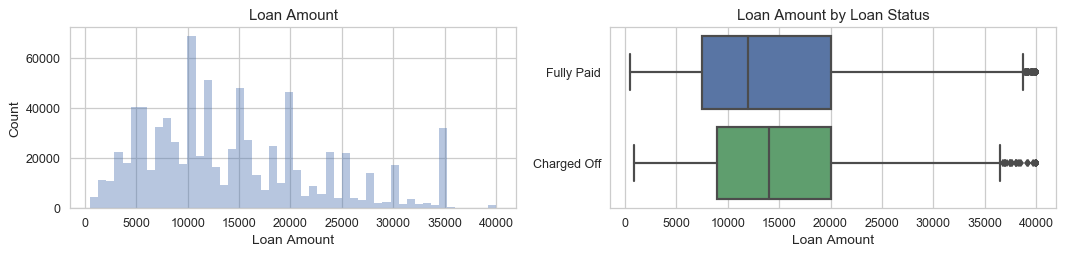

In [30]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

Charged-off loans tend to have higher loan amounts. Let's compare the summary statistics by loan status:

In [31]:
loans.groupby('loan_status')['loan_amnt'].describe()

count          mean          std    min     25%      50%  \
loan_status                                                                
Charged Off  168084.0  15384.975964  8606.476332  900.0  9000.0  14000.0   
Fully Paid   646902.0  14037.566316  8449.740674  500.0  7500.0  12000.0   

                 75%      max  
loan_status                    
Charged Off  20000.0  40000.0  
Fully Paid   20000.0  40000.0

## 5.3 term

Data Dictionary: "The number of payments on the loan. Values are in months and can be either 36 or 60."

In [32]:
loans['term'].value_counts(dropna=False)

 36 months    618460
 60 months    196526
Name: term, dtype: int64

Convert `term` to integers.

In [33]:
loans['term'] = loans['term'].apply(lambda s: np.int8(s.split()[0]))

In [34]:
loans['term'].value_counts(normalize=True)

36    0.75886
60    0.24114
Name: term, dtype: float64

Compare the charge-off rate by loan period:

In [35]:
loans.groupby('term')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

term
36    0.165710
60    0.333793
Name: loan_status, dtype: float64

About 76% of the completed loans have three-year periods, and the rest have five-year periods. Loans with five-year periods are more than twice as likely to charge-off as loans with three-year periods.

## 5.4 int_rate

Data Dictionary: "Interest Rate on the loan."

In [36]:
loans['int_rate'].describe()

count    814986.000000
mean         13.490993
std           4.618486
min           5.320000
25%           9.990000
50%          13.110000
75%          16.290000
max          30.990000
Name: int_rate, dtype: float64

Interest rates range from 5.32% to 30.99% (!) with a median of 13.1%.

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


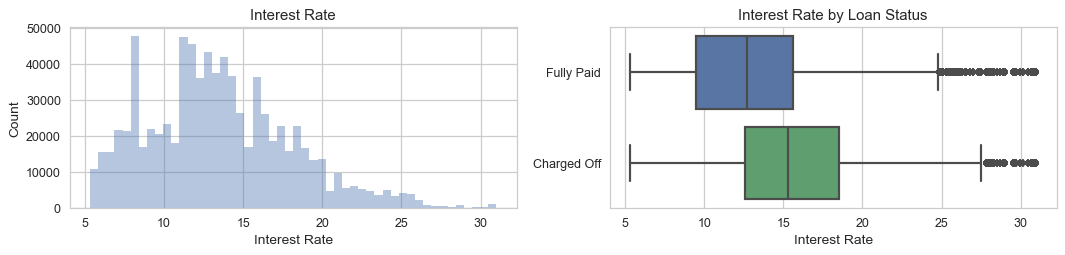

In [37]:
plot_var('int_rate', 'Interest Rate', continuous=True)

Charged-off loans tend to have much higher interest rates. Let's compare the summary statistics by loan status:

In [38]:
loans.groupby('loan_status')['int_rate'].describe()

count       mean       std   min    25%    50%    75%    max
loan_status                                                                 
Charged Off  168084.0  15.736335  4.625755  5.32  12.59  15.31  18.55  30.99
Fully Paid   646902.0  12.907587  4.434262  5.32   9.49  12.68  15.61  30.99

## 5.5 installment

Data Dictionary: "The monthly payment owed by the borrower if the loan originates."

In [39]:
loans['installment'].describe()

count    814986.000000
mean        436.749624
std         255.732093
min           4.930000
25%         251.400000
50%         377.040000
75%         576.290000
max        1714.540000
Name: installment, dtype: float64

Installments range from \$4.93 to \$1,714, with a median of \$377.

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


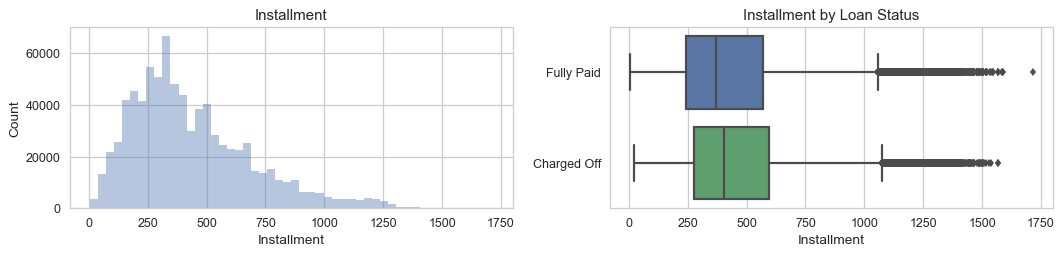

In [40]:
plot_var('installment', 'Installment', continuous=True)

Charged-off loans tend to have higher installments. Let's compare the summary statistics by loan status:

In [41]:
loans.groupby('loan_status')['installment'].describe()

count        mean         std    min     25%     50%     75%  \
loan_status                                                                    
Charged Off  168084.0  459.973673  255.309267  21.62  276.14  402.39  595.87   
Fully Paid   646902.0  430.715339  255.496761   4.93  244.76  370.92  569.72   

                 max  
loan_status           
Charged Off  1569.11  
Fully Paid   1714.54

Loans that charge off have \$30 higher installments on average.

## 5.6 grade, sub_grade

Data Dictionary for `grade`: "LendingClub assigned loan grade."

Data Dictionary for `sub_grade`: "LendingClub assigned loan subgrade."

What are the possible values of `grade` and `sub_grade`?

In [42]:
print(sorted(loans['grade'].unique()))

['A', 'B', 'C', 'D', 'E', 'F', 'G']


In [43]:
print(sorted(loans['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


The grade is implied by the subgrade, so let's drop the grade column.

In [44]:
loans.drop('grade', axis=1, inplace=True)

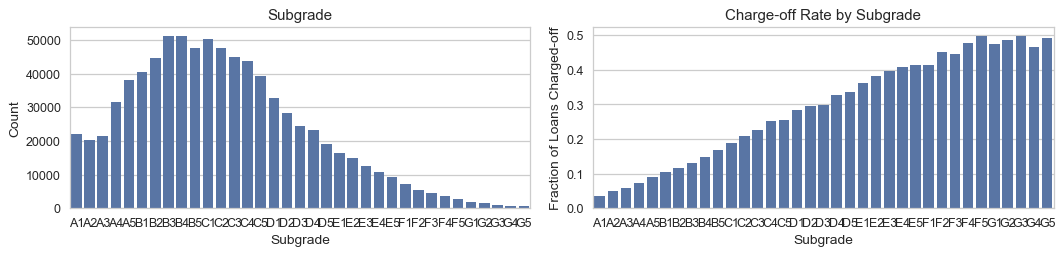

In [45]:
plot_var('sub_grade', 'Subgrade', continuous=False)

There's a clear trend of higher probability of charge-off as the subgrade worsens.

## 5.7 emp_title

Data Dictionary: "The job title supplied by the Borrower when applying for the loan."

In [46]:
loans['emp_title'].describe()

count      766415
unique     280473
top       Teacher
freq        11351
Name: emp_title, dtype: object

There are too many different job titles for this feature to be useful, so we drop it.

In [47]:
loans.drop(labels='emp_title', axis=1, inplace=True)

## 5.8 emp_length

Data Dictionary: "Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years." The actual data does not match this description:

In [48]:
loans['emp_length'].value_counts(dropna=False).sort_index()

1 year        53411
10+ years    264873
2 years       73493
3 years       64999
4 years       48752
5 years       52149
6 years       40290
7 years       39407
8 years       38887
9 years       31900
< 1 year      64572
NaN           42253
Name: emp_length, dtype: int64

Note there are 42,253 loans without data on the length of employment.

Convert `emp_length` to integers:

In [49]:
loans['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)

In [50]:
loans['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [51]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])

In [52]:
loans['emp_length'] = loans['emp_length'].apply(emp_length_to_int)

In [53]:
loans['emp_length'].value_counts(dropna=False).sort_index()

 0.0      64572
 1.0      53411
 2.0      73493
 3.0      64999
 4.0      48752
 5.0      52149
 6.0      40290
 7.0      39407
 8.0      38887
 9.0      31900
 10.0    264873
NaN       42253
Name: emp_length, dtype: int64

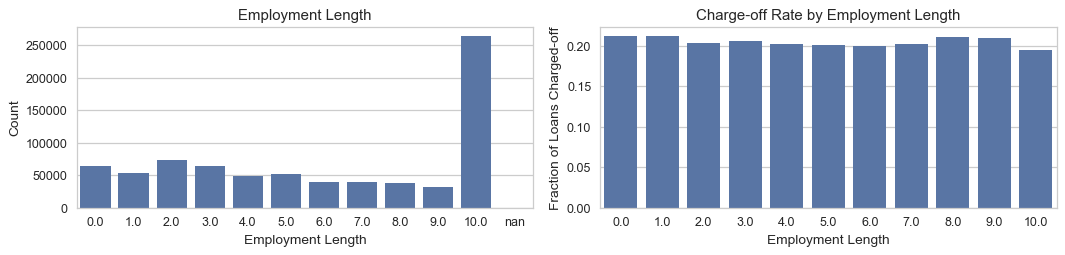

In [54]:
plot_var('emp_length', 'Employment Length', continuous=False)

Loan status does not appear to vary much with employment length on average, except for a small drop in charge-offs for borrowers with over 10 years of employment.

## 5.9 home_ownership

Data Dictionary: "The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER."

In [55]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    406866
RENT        325071
OWN          82765
OTHER          144
ANY             94
NONE            46
Name: home_ownership, dtype: int64

Replace the values `ANY` and `NONE` with `OTHER`:

In [56]:
loans['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

In [57]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    406866
RENT        325071
OWN          82765
OTHER          284
Name: home_ownership, dtype: int64

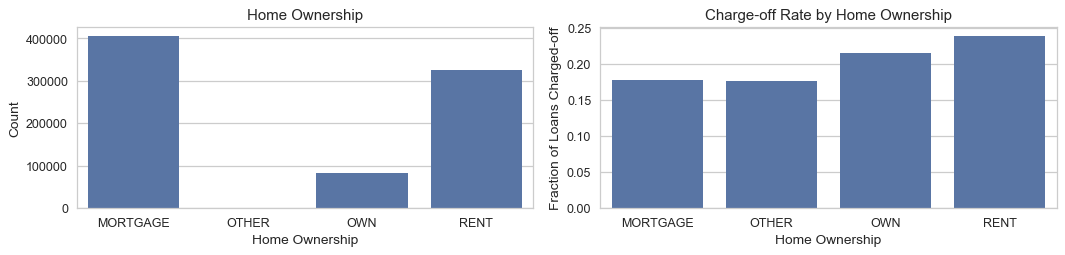

In [58]:
plot_var('home_ownership', 'Home Ownership', continuous=False)

There appear to be large differences in charge-off rates by home ownership status. Renters and homeowners have a higher probability of charge-off. Let's compare the charge-off rates:

In [59]:
loans.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

home_ownership
MORTGAGE    0.177808
OTHER       0.176056
OWN         0.215804
RENT        0.239422
Name: loan_status, dtype: float64

## 5.10 annual_inc

Data Dictionary: "The self-reported annual income provided by the borrower during registration."

In [60]:
loans['annual_inc'].describe()

count    8.149860e+05
mean     7.523039e+04
std      6.524373e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.500000e+04
75%      9.000000e+04
max      9.550000e+06
Name: annual_inc, dtype: float64

Annual income ranges from \$0 to \$9,550,000, with a median of \$65,000. Because of the large range of incomes, we should take a log transform of the annual income variable.

In [61]:
loans['log_annual_inc'] = loans['annual_inc'].apply(lambda x: np.log10(x+1))

In [62]:
loans.drop('annual_inc', axis=1, inplace=True)

In [63]:
loans['log_annual_inc'].describe()

count    814986.000000
mean          4.810836
std           0.231893
min           0.000000
25%           4.653222
50%           4.812920
75%           4.954247
max           6.980003
Name: log_annual_inc, dtype: float64

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


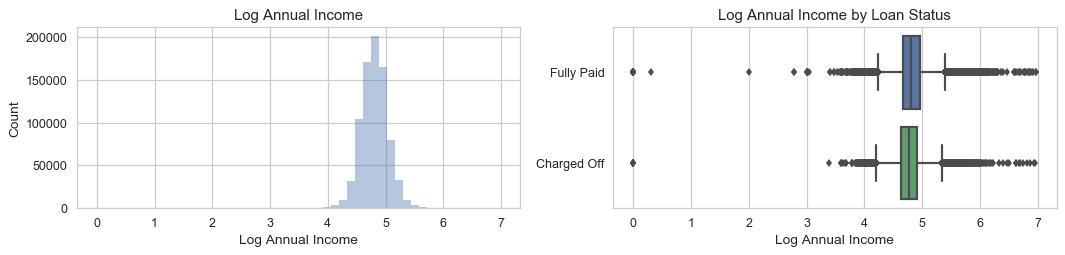

In [64]:
plot_var('log_annual_inc', 'Log Annual Income', continuous=True)

It appears that individuals with higher income are more likely to pay off their loans. Let's compare the summary statistics by loan status:

In [65]:
loans.groupby('loan_status')['log_annual_inc'].describe()

count      mean       std  min       25%       50%       75%  \
loan_status                                                                    
Charged Off  168084.0  4.777072  0.227015  0.0  4.632467  4.778158  4.915096   
Fully Paid   646902.0  4.819608  0.232342  0.0  4.672107  4.812920  4.963793   

                  max  
loan_status            
Charged Off  6.949393  
Fully Paid   6.980003

## 5.11 verification_status

Data Dictionary: "Indicates if income was verified by [Lending Club], not verified, or if the income source was verified."

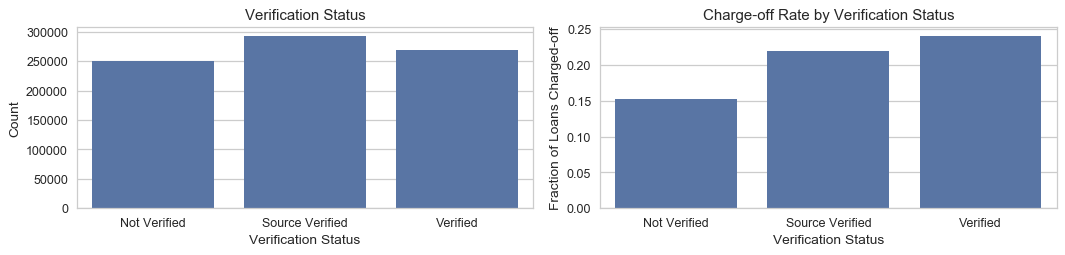

In [66]:
plot_var('verification_status', 'Verification Status', continuous=False)

## 5.12 issue_d

Data Dictionary: "The month which the loan was funded."

Because we're only using variables available to investors before the loan was funded, `issue_d` will not be included in the final model. We're keeping it for now just to perform the train/test split later, then we'll drop it.

## 5.13 purpose

Data Dictionary: "A category provided by the borrower for the loan request."

In [67]:
loans['purpose'].value_counts()

debt_consolidation    481652
credit_card           175123
home_improvement       50793
other                  43900
major_purchase         17463
small_business         10214
car                     8936
medical                 8772
moving                  5725
vacation                5116
house                   4095
wedding                 2272
renewable_energy         599
educational              326
Name: purpose, dtype: int64

Calculate the charge-off rates by purpose:

In [68]:
loans.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

purpose
wedding               0.121919
car                   0.148053
educational           0.171779
credit_card           0.178412
home_improvement      0.181383
major_purchase        0.183245
vacation              0.198788
house                 0.214652
other                 0.216970
debt_consolidation    0.217398
medical               0.229366
moving                0.242969
renewable_energy      0.247078
small_business        0.302428
Name: loan_status, dtype: float64

Notice that only 12% of completed loans for weddings have charged-off, but 30% of completed small business loans have charged-off.

## 5.14 title

Data Dictionary: "The loan title provided by the borrower."

In [69]:
loans['title'].describe()

count                 807068
unique                 60298
top       Debt consolidation
freq                  371874
Name: title, dtype: object

View the top 10 loan titles, and their frequencies:

In [70]:
loans['title'].value_counts().head(10)

Debt consolidation         371874
Credit card refinancing    133334
Home improvement            39171
Other                       33265
Debt Consolidation          15059
Major purchase              12311
Medical expenses             6908
Business                     6666
Car financing                5667
Consolidation                5090
Name: title, dtype: int64

There are 60,298 different titles in the dataset, and based on the top 10 titles, the `purpose` variable appears to already contain this information. So we drop the `title` variable.

In [71]:
loans.drop('title', axis=1, inplace=True)

## 5.15 zip_code, addr_state

Data Dictionary for `zip_code`: "The first 3 numbers of the zip code provided by the borrower in the loan application."

Data Dictionary for `addr_state`: "The state provided by the borrower in the loan application."

In [72]:
loans['zip_code'].sample(5)

1578897    325xx
449772     629xx
908626     934xx
845461     286xx
980965     334xx
Name: zip_code, dtype: object

In [73]:
loans['zip_code'].nunique()

925

In [74]:
loans['addr_state'].sample(5)

117981    AL
341171    PA
224304    NY
973786    MD
428015    MD
Name: addr_state, dtype: object

In [75]:
loans['addr_state'].nunique()

51

There are a lot of different zip codes, so let's just keep the state column.

In [76]:
loans.drop(labels='zip_code', axis=1, inplace=True)

Calculate the charge-off rates by address state:

In [77]:
loans.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

addr_state
DC    0.130378
ME    0.136564
NH    0.142554
IA    0.142857
VT    0.149225
OR    0.152827
CO    0.158083
WA    0.166538
KS    0.171004
SC    0.172705
WI    0.175315
MT    0.177759
WY    0.178142
UT    0.179049
WV    0.182457
CT    0.183810
GA    0.191224
MA    0.192974
IL    0.193302
ID    0.193487
RI    0.194009
CA    0.198303
AZ    0.199321
TX    0.202286
AK    0.204141
HI    0.204535
DE    0.206575
VA    0.207942
MI    0.208880
MN    0.210363
PA    0.214776
MD    0.214845
NC    0.215282
NJ    0.216208
KY    0.216353
MO    0.219400
FL    0.222007
OH    0.225400
NM    0.225694
SD    0.225787
NY    0.227045
IN    0.228179
TN    0.230479
NV    0.234202
ND    0.237232
LA    0.237900
AR    0.243154
AL    0.247650
OK    0.248252
NE    0.267946
MS    0.275619
Name: loan_status, dtype: float64

The charge-off rate ranges from 13.0% in Washington, DC to 27.6% in Mississippi.

## 5.16 dti

Data Dictionary: "A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."

In [78]:
loans['dti'].describe()

count    814950.000000
mean         17.867719
std           8.856477
min          -1.000000
25%          11.640000
50%          17.360000
75%          23.630000
max         999.000000
Name: dti, dtype: float64

Note sure if the values of -1 and 999 make sense...

There are several outliers that mess up our default plots. Plot a histogram for `dti` less than 60:

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Debt-to-income Ratio')

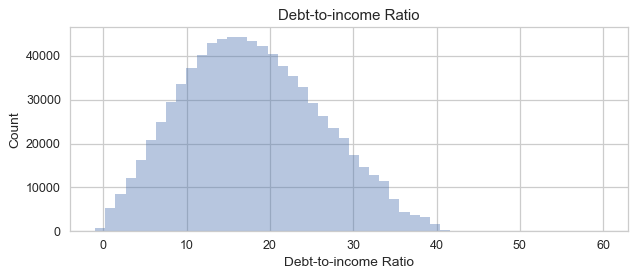

In [79]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(loans.loc[loans['dti'].notnull() & (loans['dti']<60), 'dti'], kde=False)
plt.xlabel('Debt-to-income Ratio')
plt.ylabel('Count')
plt.title('Debt-to-income Ratio')

How many of the `dti` values are "outliers" (above 60)?

In [80]:
(loans['dti']>=60).sum()

179

Very few. Compare the summary statistics by loan status:

In [81]:
loans.groupby('loan_status')['dti'].describe()

count       mean       std  min    25%    50%    75%    max
loan_status                                                                
Charged Off  168078.0  20.005334  8.991035  0.0  13.65  19.77  26.21  999.0
Fully Paid   646872.0  17.312298  8.735991 -1.0  11.22  16.77  22.90  999.0

Completed loans that are charged off tend to have higher debt-to-income ratios.

## 5.17 earliest_cr_line

Data Dictionary: "The month the borrower's earliest reported credit line was opened."

In [82]:
loans['earliest_cr_line'].sample(5)

872604    Aug-2003
975699    Oct-1999
758818    Mar-1999
274952    Aug-1971
30876     Mar-2002
Name: earliest_cr_line, dtype: object

In [83]:
loans['earliest_cr_line'].isnull().any()

False

Let's just retain the year for simplicity:

In [84]:
loans['earliest_cr_line'] = loans['earliest_cr_line'].apply(lambda s: int(s[-4:]))

In [85]:
loans['earliest_cr_line'].describe()

count    814986.000000
mean       1998.170962
std           7.385629
min        1944.000000
25%        1994.000000
50%        2000.000000
75%        2003.000000
max        2014.000000
Name: earliest_cr_line, dtype: float64

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


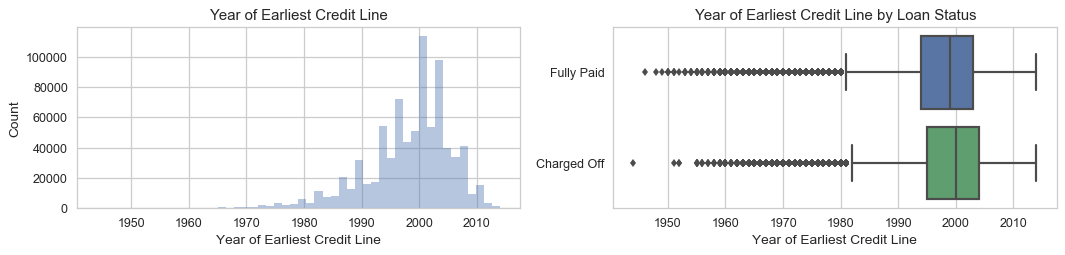

In [86]:
plot_var('earliest_cr_line', 'Year of Earliest Credit Line', continuous=True)

Borrowers who are charged-off tend to have shorter lines of credit.

## 5.18 fico_range_low, fico_range_high

Data Dictionary for `fico_range_low`: "The lower boundary range the borrower’s FICO at loan origination belongs to."

Data Dictionary for `fico_range_high`: "The upper boundary range the borrower’s FICO at loan origination belongs to."

In [87]:
loans[['fico_range_low', 'fico_range_high']].describe()

fico_range_low  fico_range_high
count   814986.000000    814986.000000
mean       695.603151       699.603264
std         31.352251        31.352791
min        625.000000       629.000000
25%        670.000000       674.000000
50%        690.000000       694.000000
75%        710.000000       714.000000
max        845.000000       850.000000

Check the Pearson correlation between these values:

In [88]:
loans[['fico_range_low','fico_range_high']].corr()

fico_range_low  fico_range_high
fico_range_low              1.0              1.0
fico_range_high             1.0              1.0

We only need to keep one of the FICO scores. We'll take the average of the two and call it `fico_score`:

In [89]:
loans['fico_score'] = 0.5*loans['fico_range_low'] + 0.5*loans['fico_range_high']

In [90]:
loans.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


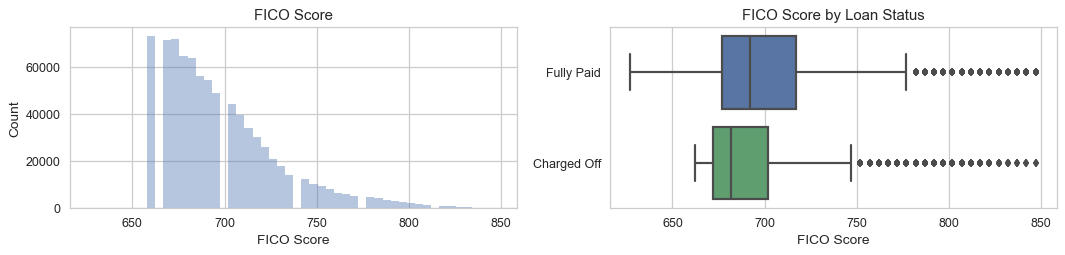

In [91]:
plot_var('fico_score', 'FICO Score', continuous=True)

There is a noticeable difference in FICO scores between fully paid and charged-off loans. Compare the summary statistics:

In [92]:
loans.groupby('loan_status')['fico_score'].describe()

count        mean        std    min    25%    50%    75%  \
loan_status                                                                
Charged Off  168084.0  689.027278  25.083105  662.0  672.0  682.0  702.0   
Fully Paid   646902.0  699.831485  32.416650  627.0  677.0  692.0  717.0   

               max  
loan_status         
Charged Off  847.5  
Fully Paid   847.5

Loans that charge off have a FICO score 10 points lower on average.

## 5.19 open_acc

Data Dictionary: "The number of open credit lines in the borrower's credit file."

Text(0.5,1,'Number of Open Credit Lines')

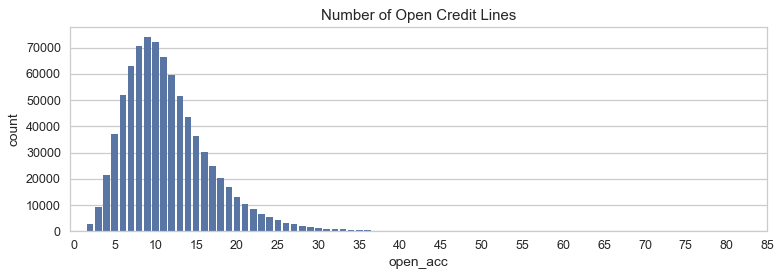

In [93]:
plt.figure(figsize=(10,3), dpi=90)
sns.countplot(loans['open_acc'], order=sorted(loans['open_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 90, 5), np.arange(0, 90, 5))
plt.title('Number of Open Credit Lines')

Is there a difference in number of credit lines between fully paid loans and charged-off loans?

In [94]:
loans.groupby('loan_status')['open_acc'].describe()

count       mean       std  min  25%   50%   75%   max
loan_status                                                           
Charged Off  168084.0  11.883094  5.515590  0.0  8.0  11.0  15.0  76.0
Fully Paid   646902.0  11.427041  5.270369  0.0  8.0  11.0  14.0  90.0

There's does not appear to be a significant difference.

## 5.20 pub_rec

Data Dictionary: "Number of derogatory public records."

In [95]:
loans['pub_rec'].value_counts().sort_index()

0.0     681509
1.0     112483
2.0      14115
3.0       4107
4.0       1400
5.0        651
6.0        338
7.0        146
8.0         90
9.0         42
10.0        28
11.0        24
12.0        15
13.0        11
14.0         2
15.0         5
16.0         2
17.0         1
18.0         3
19.0         2
21.0         1
24.0         1
28.0         2
34.0         1
40.0         1
46.0         1
49.0         2
54.0         1
63.0         1
86.0         1
Name: pub_rec, dtype: int64

Is there a difference in average public records between fully paid loans and charged-off loans?

In [96]:
loans.groupby('loan_status')['pub_rec'].describe()

count      mean       std  min  25%  50%  75%   max
loan_status                                                        
Charged Off  168084.0  0.232247  0.640855  0.0  0.0  0.0  0.0  86.0
Fully Paid   646902.0  0.198845  0.569304  0.0  0.0  0.0  0.0  63.0

## 5.21 revol_bal

Data Dictionary: "Total credit revolving balance."

In [97]:
loans['revol_bal'].describe()

count    8.149860e+05
mean     1.606864e+04
std      2.160500e+04
min      0.000000e+00
25%      6.014000e+03
50%      1.118500e+04
75%      1.972300e+04
max      2.568995e+06
Name: revol_bal, dtype: float64

Do a log transform:

In [98]:
loans['log_revol_bal'] = loans['revol_bal'].apply(lambda x: np.log10(x+1))

In [99]:
loans.drop('revol_bal', axis=1, inplace=True)

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


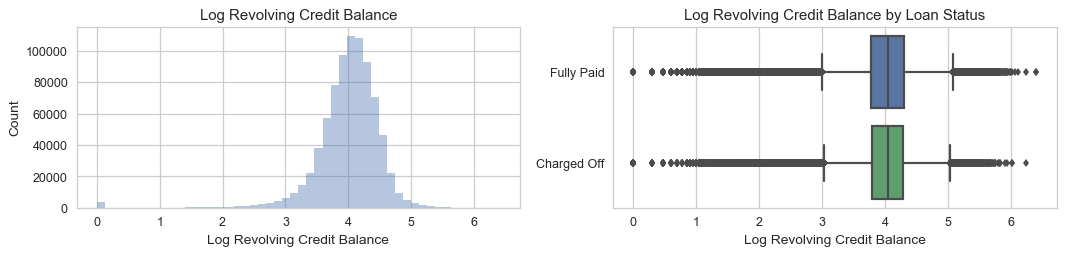

In [100]:
plot_var('log_revol_bal', 'Log Revolving Credit Balance', continuous=True)

In [101]:
loans.groupby('loan_status')['log_revol_bal'].describe()

count      mean       std  min       25%       50%       75%  \
loan_status                                                                    
Charged Off  168084.0  3.997810  0.497362  0.0  3.787602  4.051307  4.288585   
Fully Paid   646902.0  3.994933  0.527335  0.0  3.777137  4.047975  4.296665   

                  max  
loan_status            
Charged Off  6.242223  
Fully Paid   6.409763

There isn't a large difference in the means.

## 5.22 revol_util

Data Dictionary: "Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit."

In [102]:
loans['revol_util'].describe()

count    814496.000000
mean         53.031137
std          24.320981
min           0.000000
25%          35.000000
50%          53.700000
75%          71.900000
max         892.300000
Name: revol_util, dtype: float64

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


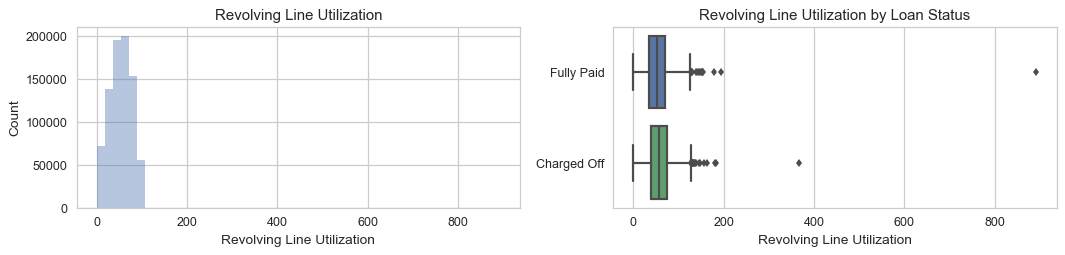

In [103]:
plot_var('revol_util', 'Revolving Line Utilization', continuous=True)

In [104]:
loans.groupby('loan_status')['revol_util'].describe()

count       mean        std  min   25%   50%   75%    max
loan_status                                                              
Charged Off  167974.0  56.475417  23.566253  0.0  39.5  57.5  74.7  366.6
Fully Paid   646522.0  52.136273  24.433954  0.0  33.9  52.7  71.0  892.3

## 5.23 total_acc

Data Dictionary: "The total number of credit lines currently in the borrower's credit file."

Text(0.5,1,'Total Number of Credit Lines')

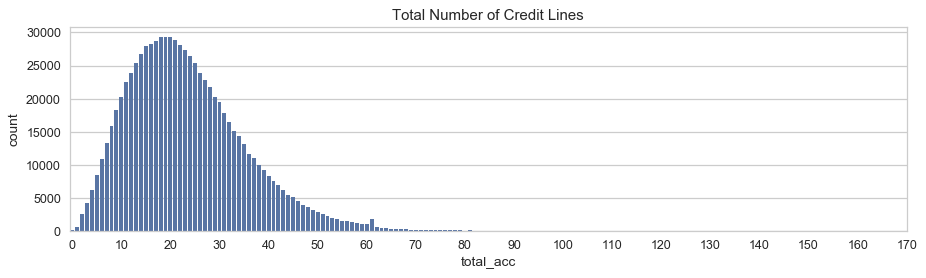

In [105]:
plt.figure(figsize=(12,3), dpi=90)
sns.countplot(loans['total_acc'], order=sorted(loans['total_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 176, 10), np.arange(0, 176, 10))
plt.title('Total Number of Credit Lines')

In [106]:
loans.groupby('loan_status')['total_acc'].describe()

count       mean        std  min   25%   50%   75%    max
loan_status                                                              
Charged Off  168084.0  25.158653  12.121106  2.0  16.0  23.0  32.0  176.0
Fully Paid   646902.0  25.489618  11.930122  2.0  17.0  24.0  32.0  156.0

No large differences here.

## 5.24 initial_list_status

Data Dictionary: "The initial listing status of the loan. Possible values are – W, F." I'm not sure what this means.

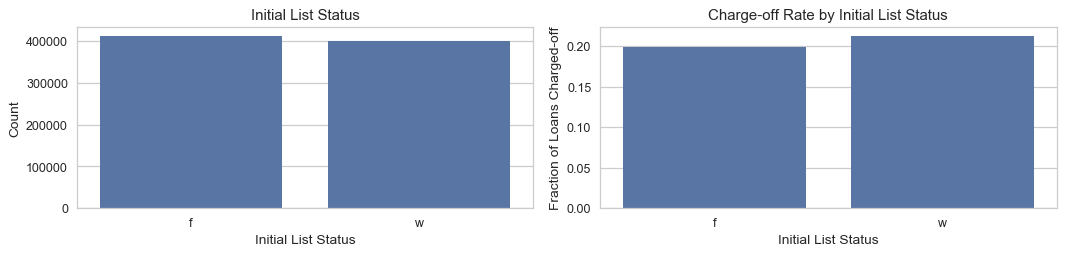

In [107]:
plot_var('initial_list_status', 'Initial List Status', continuous=False)

## 5.25 application_type

Data Dictionary: "Indicates whether the loan is an individual application or a joint application with two co-borrowers."

In [108]:
loans['application_type'].value_counts()

Individual    811207
Joint App       3779
Name: application_type, dtype: int64

Let's just compare the charge-off rates by application type:

In [109]:
loans.groupby('application_type')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

application_type
Individual    0.206316
Joint App     0.190262
Name: loan_status, dtype: float64

Joint loans are slightly less likely to be charged-off.

## 5.26 mort_acc

Data Dictionary: "Number of mortgage accounts."

In [110]:
loans['mort_acc'].describe()

count    767705.000000
mean          1.758707
std           2.081730
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          51.000000
Name: mort_acc, dtype: float64

Not sure how someone can have 51 mortgage accounts...but apparently they do. Check the top 10 values:

In [111]:
loans['mort_acc'].value_counts().head(10)

0.0    301446
1.0    131811
2.0    109869
3.0     82723
4.0     58698
5.0     37090
6.0     21817
7.0     11568
8.0      5906
9.0      3056
Name: mort_acc, dtype: int64

Compare the summary statistics by loan status:

In [112]:
loans.groupby('loan_status')['mort_acc'].describe()

count      mean       std  min  25%  50%  75%   max
loan_status                                                        
Charged Off  161198.0  1.447437  1.901888  0.0  0.0  1.0  2.0  29.0
Fully Paid   606507.0  1.841436  2.119298  0.0  0.0  1.0  3.0  51.0

Individuals who pay off their loans are more likely to have several mortgage accounts.

## 5.27 pub_rec_bankruptcies

Data Dictionary: "Number of public record bankruptcies."

In [113]:
loans['pub_rec_bankruptcies'].value_counts().sort_index()

0.0     714642
1.0      93680
2.0       4673
3.0        926
4.0        234
5.0         85
6.0         28
7.0         14
8.0          5
9.0          1
12.0         1
Name: pub_rec_bankruptcies, dtype: int64

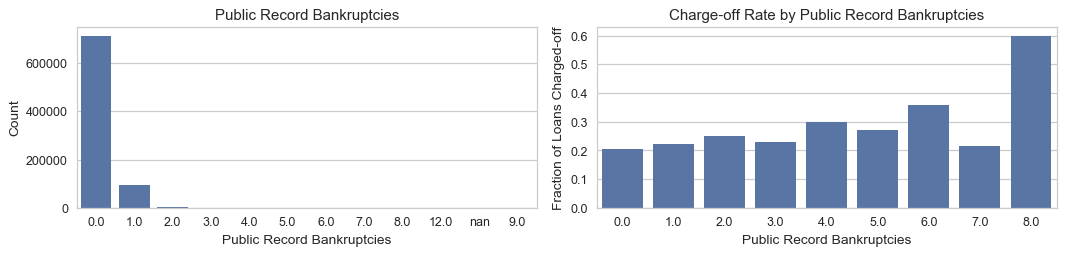

In [114]:
plot_var('pub_rec_bankruptcies', 'Public Record Bankruptcies', continuous=False)

# 6. More Pre-processing
<a id="6"></a>

## 6.1 Convert loan status to 0/1 charge-off indicator
<a id="6.1"></a>

Change the response variable `loan_status` to a 0/1 variable, where 0 indicates fully paid and 1 indicates charge-off:

In [115]:
loans['charged_off'] = (loans['loan_status'] == 'Charged Off').apply(np.uint8)
loans.drop('loan_status', axis=1, inplace=True)

## 6.2 Create dummy variables
<a id="6.2"></a>

How many variables do we currently have?

In [116]:
loans.shape

(814986, 25)

If any categorical variables have missing values, we'll need to create NaN dummy variables for those. So first check which variables have missing data:

In [117]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False) # Fraction of data missing for each variable

In [118]:
print(missing_fractions[missing_fractions > 0]) # Print variables that are missing data

mort_acc                0.058014
emp_length              0.051845
pub_rec_bankruptcies    0.000855
revol_util              0.000601
dti                     0.000044
dtype: float64


There are no categorical variables with missing values, and therefore we don't need any `NaN` dummy variables.

Create dummy variables for the categorical variables:

In [119]:
print(loans.columns)

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'verification_status', 'issue_d',
       'purpose', 'addr_state', 'dti', 'earliest_cr_line', 'open_acc',
       'pub_rec', 'revol_util', 'total_acc', 'initial_list_status',
       'application_type', 'mort_acc', 'pub_rec_bankruptcies',
       'log_annual_inc', 'fico_score', 'log_revol_bal', 'charged_off'],
      dtype='object')


In [120]:
loans = pd.get_dummies(loans, columns=['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type'], drop_first=True)

How many variables are there now?

In [121]:
loans.shape

(814986, 122)

Check our data with the new dummy variables:

In [122]:
loans.sample(5)

loan_amnt  term  int_rate  installment  emp_length   issue_d    dti  \
1550084    18000.0    36      7.89       563.15        10.0  Mar-2016  10.70   
956540     15500.0    36     15.31       539.67         4.0  Oct-2012  25.68   
99139      15000.0    36     16.99       534.72         4.0  Aug-2014  23.56   
832384      2750.0    36     19.20       101.09         NaN  Nov-2013  10.50   
179977     14000.0    36     10.99       458.28         7.0  Apr-2014  15.60   

         earliest_cr_line  open_acc  pub_rec  revol_util  total_acc  mort_acc  \
1550084              1992      25.0      0.0        12.0       46.0       0.0   
956540               1999      12.0      0.0        38.3       29.0       1.0   
99139                1995      16.0      0.0        48.2       26.0       4.0   
832384               2009       4.0      0.0        48.2        5.0       0.0   
179977               2003       6.0      0.0        94.1       12.0       3.0   

         pub_rec_bankruptcies  log_annual_inc  fico_score  log_revol_bal  \
1550084                   0.0        4.903095       707.0       3.772835   
956540                    0.0        4.653222       697.0       4.050534   
99139                     0.0        4.913819       677.0       4.306275   
832384                    0.0        4.079217       667.0       3.596927   
179977                    0.0        4.819551       672.0       4.214128   

         charged_off  sub_grade_A2  sub_grade_A3  sub_grade_A4  sub_grade_A5  \
1550084            0             0             0             0             1   
956540             0             0             0             0             0   
99139              0             0             0             0             0   
832384             1             0             0             0             0   
179977             1             0             0             0             0   

         sub_grade_B1  sub_grade_B2  sub_grade_B3  sub_grade_B4  sub_grade_B5  \
1550084             0             0             0             0             0   
956540              0             0             0             0             0   
99139               0             0             0             0             0   
832384              0             0             0             0             0   
179977              0             1             0             0             0   

         sub_grade_C1  sub_grade_C2  sub_grade_C3  sub_grade_C4  sub_grade_C5  \
1550084             0             0             0             0             0   
956540              0             1             0             0             0   
99139               0             0             0             0             0   
832384              0             0             0             0             0   
179977              0             0             0             0             0   

         sub_grade_D1  sub_grade_D2  sub_grade_D3  sub_grade_D4  sub_grade_D5  \
1550084             0             0             0             0             0   
956540              0             0             0             0             0   
99139               0             0             1             0             0   
832384              0             0             1             0             0   
179977              0             0             0             0             0   

         sub_grade_E1  sub_grade_E2  sub_grade_E3  sub_grade_E4  sub_grade_E5  \
1550084             0             0             0             0             0   
956540              0             0             0             0             0   
99139               0             0             0             0             0   
832384              0             0             0             0             0   
179977              0             0             0             0             0   

         sub_grade_F1  sub_grade_F2  sub_grade_F3  sub_grade_F4  sub_grade_F5  \
1550084             0             0             0             0           

## 6.3 Train/test split
<a id="6.3"></a>

We'll make our modeling problem more realistic by performing the train/test split based on the month that the loan was funded. That is, we'll use loans funded on earlier dates to predict whether future loans will charge-off. The variable `issue_d` includes the month and year that the loan was funded.

In [123]:
loans['issue_d'].sample(5)

1559071    Mar-2016
1577670    Feb-2016
629412     Mar-2015
133052     Jul-2014
693233     Jan-2015
Name: issue_d, dtype: object

Are there any missing values?

In [124]:
loans['issue_d'].isnull().any()

False

No. Let's convert the issue dates to datetime objects:

In [125]:
loans['issue_d'] = pd.to_datetime(loans['issue_d'])

In [126]:
loans['issue_d'].sample(5)

888937   2013-06-01
27556    2014-11-01
698033   2015-01-01
891384   2013-06-01
669716   2015-01-01
Name: issue_d, dtype: datetime64[ns]

The new datetime values are all on the first day of the month. Check the summary statistics of the issue dates:

In [127]:
loans['issue_d'].describe()

count                  814986
unique                    124
top       2014-10-01 00:00:00
freq                    33699
first     2007-06-01 00:00:00
last      2017-09-01 00:00:00
Name: issue_d, dtype: object

There are only 124 unique issue dates over the 10-year period because we only have month/year information. In this particular dataset, the first loans were issued in June 2007, and the most recent loans were issued in September 2017. The busiest month was October 2014 with 33,699 loans funded in that month. What is the distribution of loans funded in each year?

Text(0.5,1,'Loans Funded per Year')

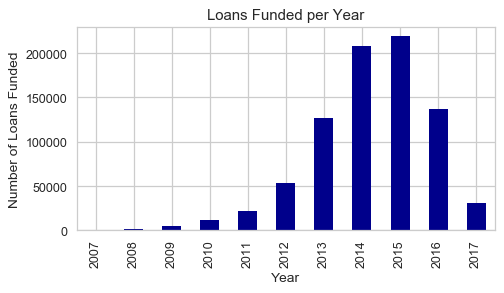

In [128]:
plt.figure(figsize=(6,3), dpi=90)
loans['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of Loans Funded')
plt.title('Loans Funded per Year')

We'll form the test set from the most recent 10% of the loans.

In [129]:
loans_train = loans.loc[loans['issue_d'] <  loans['issue_d'].quantile(0.9)]
loans_test =  loans.loc[loans['issue_d'] >= loans['issue_d'].quantile(0.9)]

Check that we properly partitioned the loans:

In [130]:
print('Number of loans in the partition:   ', loans_train.shape[0] + loans_test.shape[0])
print('Number of loans in the full dataset:', loans.shape[0])

Number of loans in the partition:    814986
Number of loans in the full dataset: 814986


What is the test size?

In [131]:
loans_test.shape[0] / loans.shape[0]

0.10291955935439381

About 10.2%. The partition looks good, so we can delete the original `loans` dataframe:

In [132]:
del loans

Let's look at the summary statistics of the issue dates in the train and test sets:

In [133]:
loans_train['issue_d'].describe()

count                  731108
unique                    109
top       2014-10-01 00:00:00
freq                    33699
first     2007-06-01 00:00:00
last      2016-06-01 00:00:00
Name: issue_d, dtype: object

In [134]:
loans_test['issue_d'].describe()

count                   83878
unique                     15
top       2016-07-01 00:00:00
freq                    10825
first     2016-07-01 00:00:00
last      2017-09-01 00:00:00
Name: issue_d, dtype: object

The training set includes loans from June 2007 to June 2016. The test set includes loans from July 2016 to September 2017.

Now we need to delete the `issue_d` variable, because it was not available before the loan was funded.

In [135]:
loans_train.drop('issue_d', axis=1, inplace=True)
loans_test.drop('issue_d', axis=1, inplace=True)

Now separate the predictor variables from the response variable:

In [136]:
y_train = loans_train['charged_off']
y_test = loans_test['charged_off']

In [137]:
X_train = loans_train.drop('charged_off', axis=1)
X_test = loans_test.drop('charged_off', axis=1)

In [138]:
del loans_train, loans_test

# 7. Linear Dependence of Charge-off on the Predictors
<a id="7"></a>

On the training set, we compute the Pearson correlation, $F$-statistic, and $p$ value of each predictor with the response variable `charged_off`.

In [139]:
linear_dep = pd.DataFrame()

Pearson correlations:

In [140]:
for col in X_train.columns:
    linear_dep.loc[col, 'pearson_corr'] = X_train[col].corr(y_train)
linear_dep['abs_pearson_corr'] = abs(linear_dep['pearson_corr'])

$F$-statistics:

In [141]:
from sklearn.feature_selection import f_classif
for col in X_train.columns:
    mask = X_train[col].notnull()
    (linear_dep.loc[col, 'F'], linear_dep.loc[col, 'p_value']) = f_classif(pd.DataFrame(X_train.loc[mask, col]), y_train.loc[mask])

Sort the results by the absolute value of the Pearson correlation:

In [142]:
linear_dep.sort_values('abs_pearson_corr', ascending=False, inplace=True)
linear_dep.drop('abs_pearson_corr', axis=1, inplace=True)

Reset the index:

In [143]:
linear_dep.reset_index(inplace=True)
linear_dep.rename(columns={'index':'variable'}, inplace=True)

View the results for the top 20 predictors most correlated with `charged_off`:

In [144]:
linear_dep.head(20)

variable  pearson_corr             F  p_value
0                       int_rate      0.256691  51570.855220      0.0
1                           term      0.188604  26965.820737      0.0
2                     fico_score     -0.139928  14600.790875      0.0
3                            dti      0.131005  12766.403302      0.0
4                       mort_acc     -0.076676   4044.121007      0.0
5                 log_annual_inc     -0.074252   4053.225270      0.0
6                   sub_grade_A4     -0.069089   3506.566794      0.0
7                     revol_util      0.066569   3252.333239      0.0
8                   sub_grade_A5     -0.066226   3220.711982      0.0
9                      loan_amnt      0.063598   2969.118688      0.0
10           home_ownership_RENT      0.063576   2967.107649      0.0
11                  sub_grade_A2     -0.062767   2891.694037      0.0
12                  sub_grade_A3     -0.062051   2825.878474      0.0
13                  sub_grade_E2      0.060711   2704.674296      0.0
14                  sub_grade_E3      0.060043   2645.273355      0.0
15                  sub_grade_E4      0.058985   2552.541431      0.0
16                  sub_grade_E5      0.057718   2443.729458      0.0
17                  sub_grade_B1     -0.057400   2416.802596      0.0
18  verification_status_Verified      0.056540   2344.706287      0.0
19                  sub_grade_E1      0.056529   2343.731745      0.0

The variables most linearly correlated with `charged_off` are the interest rate, loan period (term), FICO score, debt-to-income ratio, number of mortgages, income, the loan grade, and the loan amount.

Now view the results for the 20 least correlated predictors:

In [145]:
linear_dep.tail(20)

variable  pearson_corr         F   p_value
100             addr_state_ND      0.002876  6.048675  0.013917
101             addr_state_KY      0.002838  5.890675  0.015222
102              sub_grade_C2      0.002769  5.607547  0.017884
103             addr_state_MD      0.002663  5.184521  0.022789
104  purpose_renewable_energy      0.002634  5.070839  0.024332
105             addr_state_SD      0.002580  4.866787  0.027379
106             addr_state_ME     -0.002400  4.212869  0.040119
107             addr_state_ID      0.002174  3.455750  0.063033
108             addr_state_AZ     -0.002092  3.201519  0.073570
109       purpose_educational     -0.001986  2.884806  0.089419
110             addr_state_RI     -0.001603  1.879509  0.170390
111             addr_state_MI      0.001580  1.823772  0.176865
112      home_ownership_OTHER     -0.001233  1.110832  0.291902
113             addr_state_MN      0.001140  0.950030  0.329712
114             addr_state_VA      0.001014  0.750969  0.386170
115             log_revol_bal     -0.000803  0.471145  0.492461
116             addr_state_IA     -0.000511  0.190680  0.662351
117             addr_state_DE      0.000506  0.187470  0.665031
118             addr_state_HI      0.000170  0.021066  0.884599
119          purpose_vacation     -0.000074  0.003921  0.950072

It looks like the borrower's state of residence, the revolving balance, and several of the loan purposes are irrelevant for predicting charge-off.

# 8. Model Training and Testing
<a id="8"></a>

We implement machine learning pipelines consisting of one or more of the following steps, depending on the particular model:
1. Mean imputation of missing values
2. Dimension reduction using linear discriminant analysis (LDA)
3. Data standardization: rescaling to zero mean and unit variance
4. The chosen model

We will evaluate and compare the following models using a cross-validated AUROC score on the training set:
1. Logistic regression with SGD training
2. Random forest
3. k-nearest neighbors

We'll perform some hyperparameter tuning for each model to choose the most promising model, then more carefully tune the hyperparameters of the best-performing model.

In [146]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

## 8.1 Logistic regression with SGD training
<a id="8.1"></a>

The `SGDClassifier` estimator in scikit-learn implements linear classifiers (SVM, logistic regression, and others) with stochastic gradient descent (SGD) training. A particular linear classifier is chosen through the `loss` hyperparameter. Because we want to predict the probability of charge-off, we choose logistic regression (a probabilistic classifier) by setting `loss = 'log'`.

In [147]:
from sklearn.linear_model import SGDClassifier

The machine learning pipeline:

In [148]:
pipeline_sgdlogreg = Pipeline([
    ('imputer', Imputer(copy=False)), # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('model', SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

A small grid of hyperparameters to search over:

In [149]:
param_grid_sgdlogreg = {
    'model__alpha': [10**-5, 10**-2, 10**1],
    'model__penalty': ['l1', 'l2']
}

Create the search grid object:

In [150]:
grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

Conduct the grid search and train the final model on the whole dataset:

In [151]:
grid_sgdlogreg.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=False, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=False, with_mean=True, with_std=True)), ('model', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       e...ty='l2', power_t=0.5, random_state=1, shuffle=True,
       tol=0.001, verbose=0, warm_start=True))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'model__alpha': [1e-05, 0.01, 10], 'model__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the best model:

In [152]:
grid_sgdlogreg.best_score_

0.7138651282339733

Best hyperparameters:

In [153]:
grid_sgdlogreg.best_params_

{'model__alpha': 0.01, 'model__penalty': 'l2'}

## 8.2 Random forest classifier
<a id="8.2"></a>

Next we train a random forest model. Note that data standardization is not necessary for a random forest.

In [154]:
from sklearn.ensemble import RandomForestClassifier

In [155]:
pipeline_rfc = Pipeline([
    ('imputer', Imputer(copy=False)),
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])

The random forest takes very long to train, so we don't test different hyperparameter choices. We'll still use `GridSearchCV` for the sake of consistency.

In [156]:
param_grid_rfc = {
    'model__n_estimators': [50] # The number of randomized trees to build
}

The AUROC will always improve (with decreasing gains) as the number of estimators increases, but it's not necessarily worth the extra training time and model complexity.

In [157]:
grid_rfc = GridSearchCV(estimator=pipeline_rfc, param_grid=param_grid_rfc, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

In [158]:
grid_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=False, missing_values='NaN', strategy='mean', verbose=0)), ('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_im...stimators=10, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'model__n_estimators': [50]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=False, scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the random forest:

In [159]:
grid_rfc.best_score_

0.6972644945776202

Not quite as good as logistic regression, at least according to this metric.

## 8.3 k-nearest neighbors
<a id="8.3"></a>

Next we try k-nearest neighbors. We need to reduce the number of variables to 10 or fewer ([reference](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#Dimension_reduction)) for kNN to perform well. We'll use LDA for dimension reduction. The number of component variables to keep is a hyperparameter.

In [160]:
from sklearn.neighbors import KNeighborsClassifier

In [161]:
pipeline_knn = Pipeline([
    ('imputer', Imputer(copy=False)),
    ('scaler', StandardScaler(copy=False)),
    ('lda', LinearDiscriminantAnalysis()),
    ('model', KNeighborsClassifier(n_jobs=-1))
])

In [162]:
param_grid_knn = {
    'lda__n_components': [3, 9], # Number of LDA components to keep
    'model__n_neighbors': [5, 25, 125] # The 'k' in k-nearest neighbors
}

In [163]:
grid_knn = GridSearchCV(estimator=pipeline_knn, param_grid=param_grid_knn, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

In [164]:
grid_knn.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=False, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=False, with_mean=True, with_std=True)), ('lda', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
          ...ski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'lda__n_components': [3, 9], 'model__n_neighbors': [5, 25, 125]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the best model:

In [165]:
grid_knn.best_score_

0.7098796124703738

Best hyperparameters:

In [166]:
grid_knn.best_params_

{'lda__n_components': 3, 'model__n_neighbors': 125}

Only 3 LDA components are necessary for kNN to perform almost as well as logistic regression.

## 8.4 Tune hyperparameters on the chosen model more finely
<a id="8.4"></a>

The three models performed quite similarly according to the AUROC:

In [167]:
print('Cross-validated AUROC scores')
print(grid_sgdlogreg.best_score_, '- Logistic regression')
print(grid_rfc.best_score_, '- Random forest')
print(grid_knn.best_score_, '- k-nearest neighbors')

Cross-validated AUROC scores
0.7138651282339733 - Logistic regression
0.6972644945776202 - Random forest
0.7098796124703738 - k-nearest neighbors


Logistic regression squeaked out ahead, and coupled with the fact that `SGDClassifier` trains much faster than the other two models, we'll select logistic regression as our final model. Now we'll tune the hyperparameters more finely.

In [168]:
param_grid_sgdlogreg = {
    'model__alpha': np.logspace(-4.5, 0.5, 11), # Fills in the gaps between 10^-5 and 10^1
    'model__penalty': ['l1', 'l2']
}

print(param_grid_sgdlogreg)

{'model__alpha': array([3.16227766e-05, 1.00000000e-04, 3.16227766e-04, 1.00000000e-03,
       3.16227766e-03, 1.00000000e-02, 3.16227766e-02, 1.00000000e-01,
       3.16227766e-01, 1.00000000e+00, 3.16227766e+00]), 'model__penalty': ['l1', 'l2']}


In [169]:
grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

In [170]:
grid_sgdlogreg.fit(X_train, y_train)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:  9.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=False, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=False, with_mean=True, with_std=True)), ('model', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       e...ty='l2', power_t=0.5, random_state=1, shuffle=True,
       tol=0.001, verbose=0, warm_start=True))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'model__alpha': array([3.16228e-05, 1.00000e-04, 3.16228e-04, 1.00000e-03, 3.16228e-03,
       1.00000e-02, 3.16228e-02, 1.00000e-01, 3.16228e-01, 1.00000e+00,
       3.16228e+00]), 'model__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the best model:

In [171]:
grid_sgdlogreg.best_score_

0.7138651282339733

Best hyperparameters:

In [172]:
grid_sgdlogreg.best_params_

{'model__alpha': 0.01, 'model__penalty': 'l2'}

By some coincidence, the optimal hyperparameters here are the same as those from our first grid search for logistic regression!

## 8.5 Test set evaluation
<a id="8.5"></a>

Now we can finally see how our chosen model performs on the test data (the most recent 10% of the loans).

In [173]:
from sklearn.metrics import roc_auc_score

In [174]:
y_score = grid_sgdlogreg.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_score)

0.6893909107572427

The test set AUROC score is somewhat lower than the cross-validated score (0.713).

# 9. Conclusion
<a id="9"></a>

We applied machine learning methods to predict the probability that a requested loan on LendingClub will charge off. After training and evaluating three different models (logistic regression, random forest, and k-nearest neighbors), we found that all three performed similarly according to a cross-validated AUROC score on the training data. We selected logistic regression (with ridge penalty) because it was the fastest model to train, and this model obtained an AUROC score of 0.689 on a test set consisting of the most recent 10% of the loans.

This model, while far from perfect, can provide a somewhat informed prediction of the likelihood that a loan will charge off, using only data available to potential investors before the loan is fully funded.

We also found that, according to the Pearson correlations between the predictors and the response, the most important variables for predicting charge-off are the loan interest rate and term, and the borrower's FICO score and debt-to-income ratio.